# Lepton - Jet Asymmetry

### $\phi$ is defined as the angle between the total transverse momentum of the system,

### $\vec{q}_\perp = \vec{k}_{\ell\perp} + \vec{k}_{J\perp}$, 

### and the jet relative momentum,

### $\vec{P_\perp} = (\vec{k}_{\ell\perp} - \vec{k}_{J\perp})/2$

### Thus:

### $\cos(\phi) = (\vec{q}_\perp \cdot \vec{P_\perp})\ /\ |\vec{q}_\perp| |\vec{P_\perp}|$

### and $\phi = \mathrm{acos}[(\vec{q}_\perp \cdot \vec{P_\perp})\ /\ |\vec{q}_\perp| |\vec{P_\perp}|]$

### Assumption: Perturbative iff $\vec{q}_\perp << \vec{P_\perp}$

### Note: $\hat{t} = (k_l-k)^2 = -Q^2$

https://arxiv.org/pdf/2106.05307.pdf

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from matplotlib import gridspec
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import h5py

import os
os.environ['CUDA_VISIBLE_DEVICES']="2"

physical_devices = tf.config.list_physical_devices('GPU')
print("Number of GPUs:",len(physical_devices))
print(physical_devices)

tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of GPUs: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Read in Data and MC

In [2]:
#data = pd.read_pickle("/clusterfs/ml4hep/yxu2/unfolding_mc_inputs/Data_nominal.pkl")
#mc = pd.read_pickle("/clusterfs/ml4hep/yxu2/unfolding_mc_inputs/Django_nominal.pkl")
mc = pd.read_pickle("/clusterfs/ml4hep/yxu2/unfolding_mc_inputs/Rapgap_nominal.pkl")

### Select Leading Jets Only

In [3]:
njets_tot = len(mc["jet_pt"])
mc = mc.loc[(slice(None),0), :]

print("Number of subjets cut = ",njets_tot-len(mc["e_px"])," / ",len(mc["jet_pt"]))

Number of subjets cut =  30063127  /  54120771


### $\theta_{G}$

In [4]:
theta0_G = mc[['gene_px','gene_py','gene_pz','genjet_pt','genjet_eta','genjet_phi','genjet_dphi','genjet_qtnorm']].to_numpy()
weights_MC_sim = mc['wgt']
pass_reco = np.array(mc['pass_reco'])
pass_truth = np.array(mc['pass_truth'])
pass_fiducial = np.array(mc['pass_fiducial'])
del mc
_ = gc.collect()

In [5]:
print(np.sum(pass_fiducial)/len(pass_fiducial))

0.22198484570739024


In [6]:
weights = weights_MC_sim

---

### $\vec{q}_\perp = \vec{k}_{\ell\perp} + \vec{k}_{J\perp}$  and  $\vec{P_\perp} = (\vec{k}_{\ell\perp} - \vec{k}_{J\perp})/2$
### $\cos(\phi) = (\vec{q}_\perp \cdot \vec{P_\perp})\ /\ |\vec{q}_\perp| |\vec{P_\perp}|$

In [7]:
e_px = theta0_G[:,0]
e_py = theta0_G[:,1]

jet_pT_mag = theta0_G[:,3]
jet_phi = theta0_G[:,5]
print(min(jet_pT_mag))

jet_qT = theta0_G[:,7] #[not to be confused with q_Perp!]

print(min(jet_phi),max(jet_phi))
print(min(jet_pT_mag))

jet_px = np.multiply(jet_pT_mag, np.cos(jet_phi))
jet_py = np.multiply(jet_pT_mag, np.sin(jet_phi))

jet_pT = np.array([jet_px,jet_py])
e_pT = np.array([e_px,e_py])

q_perp_vec = jet_pT + e_pT
P_perp_vec = (e_pT-jet_pT)/2

q_perp_mag = np.linalg.norm(q_perp_vec,axis=0)
P_perp_mag = np.linalg.norm(P_perp_vec,axis=0)



q_dot_P = q_perp_vec[0,:]*P_perp_vec[0,:] + q_perp_vec[1,:]*P_perp_vec[1,:]

cosphi = (q_dot_P)/(q_perp_mag*P_perp_mag)
asymm_phi = np.arccos(cosphi)
#7.32459e-08 6.283185
print(np.shape(q_perp_mag))
print(np.shape(jet_phi))
print(np.shape(asymm_phi))

3.0000005
1.7457504e-07 6.283185
3.0000005
(54120771,)
(54120771,)
(54120771,)


/tmp/ipykernel_21269/1280418166.py:30: RuntimeWarning: invalid value encountered in arccos
  asymm_phi = np.arccos(cosphi)


### Define Cuts

In [8]:
#pass_fiducial created under theta_G
pT_cut = jet_pT_mag > 10.
q_over_pT_cut = q_perp_mag/jet_pT_mag < 0.3 #Kyle guessed ~0.3, needs variation
qT_cut = np.where((jet_qT<0.25), True, False)
phi_nan_cut = ~np.isnan(asymm_phi)
#q_perp_cut = q_perp_mag < 0.3 #q_perp_max

print(np.shape(pT_cut))


cut_arrays = [pass_fiducial,
              pT_cut,
              q_over_pT_cut,
              qT_cut,
              phi_nan_cut]
              #q_perp_cut]

cuts = np.ones(len(pT_cut))

for cut in cut_arrays:
    print(np.shape(cut))
    cuts = np.logical_and(cuts,cut)

(54120771,)
(54120771,)
(54120771,)
(54120771,)
(54120771,)
(54120771,)


___

### Asymmetry Histogram

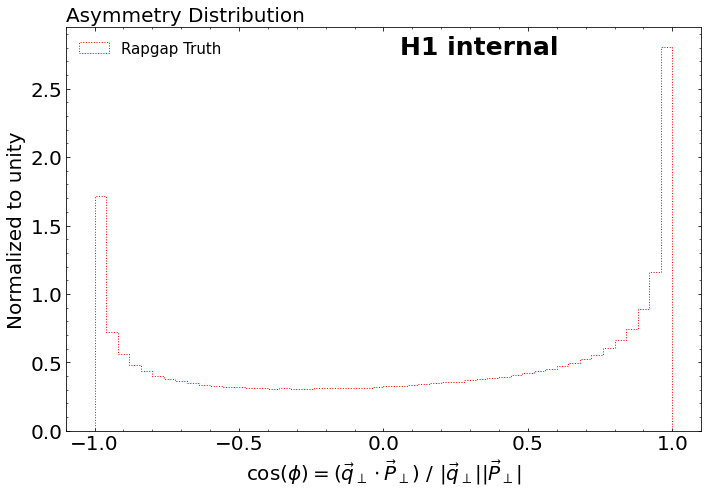

In [11]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=0)
plt.yticks(fontsize=20)
#bin_for_angle = np.linspace(0,3,18)
bin_for_angle = np.linspace(-1,1,51)


a_sim,b_sim,c=plt.hist(cosphi[cuts], bins = bin_for_angle,
                weights=weights_MC_sim[cuts],
                density=True,histtype="step",color="red",ls=":",label="Rapgap Truth")

plt.ylabel("Normalized to unity",fontsize=20)
plt.title("Asymmetry Distribution ",loc="left",fontsize=20)
plt.text(0.65, 0.95,'H1 internal', horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.legend(frameon=False,fontsize=15,loc='upper left')
plt.locator_params(axis='x', nbins=5)
#plt.yscale("log")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20),

#plt.xlabel(r"$cos(\phi) = q_T\cdot e_{p_T}/(|q_T|\cdot|e_{p_T}|)$",fontsize=15)
plt.xlabel(r'cos($\phi) = (\vec{q}_\perp \cdot \vec{P}_\perp)\ /\ |\vec{q}_\perp| |\vec{P}_\perp|$',fontsize=20)

plt.savefig("Rapgap_Angle_Distribution.pdf")
plt.tight_layout()
plt.show()

In [10]:
#np.save('qT_masks',qT_masks)
np.save('rapgap_jet_pT',jet_pT_mag)
np.save('rapgap_cuts',cuts)
np.save('rapgap_q_perp',q_perp_mag)
np.save('rapgap_asymm_angle',asymm_phi)
np.save('rapgap_weights',weights)